# MNIST - Keras / SHAP

Shap works best with Keras, so that's what we'll use for this one.



In [1]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import random
import pickle
import os

# cache locally
if not os.path.exists('./mnist.pickle'):
    print('No cached MNIST data, downloading...')
    mnist = fetch_openml('mnist_784', data_home='../datasets')
    pickle.dump(data, open('./mnist.pickle', 'wb'))
else:
    print('Unpacking MNIST from cache...')
    mnist = pickle.load(open('./mnist.pickle', 'rb'))
    
print(mnist.DESCR)

Unpacking MNIST from cache...
**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images we

In [2]:
import numpy as np

# training data
X_trn = mnist.data.iloc[0:60000].to_numpy().astype('float32')
X_trn = X_trn.reshape(X_trn.shape[0], 28, 28) # reshape to images
y_trn = mnist.target.iloc[0:60000].to_numpy().astype('float32')

y_trn = np.vstack([y for y in y_trn]) # jankily turn this into a column vector

# test data
X_tst = mnist.data.iloc[60000:70000].to_numpy().astype('float32')
X_tst = X_tst.reshape(X_tst.shape[0], 28, 28) # reshape to images
y_tst = mnist.target.iloc[60000:70000].to_numpy().astype('float32')
y_tst = np.vstack([y for y in y_tst])

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

I'm recreating the network from the pytorch explanation exploration with LIME:

```python
Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64,  bias=True)
    (5): ReLU()
    (6): Linear(in_features=64,  out_features=10,  bias=True)
    (7): LogSoftmax(dim=1)
)
```

The Pytorch model used NLL, and the Keras categorical crossentropy is equivalent (probably).

Conversion to Keras (bastardized from [the docs](https://keras.io/getting_started/intro_to_keras_for_engineers/)):

In [4]:
def create_model(class_count=10, name=''):
    # inputs are 28 x 28 monochromatic single channel images,
    # which come pre-flattened from the dataset
    inputs = keras.Input(shape=(28,28))

    # next, scale to 0,1
    rescaled = layers.experimental.preprocessing.Rescaling(scale=1.0 / 255)(inputs)
    x = layers.Flatten()(rescaled)
    
    # 3x ReLU activated linear layers of 784 -> 128 -> 128 -> 64
    x = layers.Dense(128, activation='relu')(x)  # 784 -> 128
    x = layers.Dense(128, activation='relu')(x)  # 128 -> 128
    x = layers.Dense(64,  activation='relu')(x)  # 128 -> 64
    
    # 1x softmax-activaed linear layer of 64 -> class_count
    outputs = layers.Dense(class_count,  activation='softmax')(x) # 64  -> 10 (no activation)
    
    # create the model
    model = keras.Model(inputs, outputs, name=name)
    model.summary()
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )
    
    return model

In [5]:
full_model = create_model(class_count=10, name='full_mnist_model')

Model: "full_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling (Rescaling)        (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)           

To train the model, we use Keras' default `fit(...)` routine, with 15 epochs to match the Pytorch training.

In [6]:
%%time
full_model.fit(
    X_trn,
    y_trn,
    batch_size=64, 
    epochs=15,
    validation_data=(X_tst, y_tst)
)

Epoch 1/15
938/938 [==============================] - 2s 2ms/step - loss: 0.4871 - acc: 0.8569 - val_loss: 0.1356 - val_acc: 0.9567
Epoch 2/15
938/938 [==============================] - 1s 1ms/step - loss: 0.1102 - acc: 0.9669 - val_loss: 0.0955 - val_acc: 0.9721
Epoch 3/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0765 - acc: 0.9768 - val_loss: 0.0904 - val_acc: 0.9716
Epoch 4/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0531 - acc: 0.9835 - val_loss: 0.0814 - val_acc: 0.9751
Epoch 5/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0416 - acc: 0.9867 - val_loss: 0.0792 - val_acc: 0.9771
Epoch 6/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0336 - acc: 0.9896 - val_loss: 0.0908 - val_acc: 0.9748
Epoch 7/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0298 - acc: 0.9904 - val_loss: 0.0813 - val_acc: 0.9772
Epoch 8/15
938/938 [==============================] - 1s 1ms/step - loss: 0.

In [7]:
loss, acc = full_model.evaluate(X_tst, y_tst)  # returns loss and metrics
print(f'Model performance:\n\tLoss:\t{loss:.6f}\n\tAcc:\t{acc:.6f}')

313/313 [==============================] - 0s 597us/step - loss: 0.1079 - acc: 0.9785
Model performance:
	Loss:	0.107922
	Acc:	0.978500


Predict a random index for spot verification:

Predictions for idx 8714: 
[1.5942269e-22 8.7126411e-13 1.0000000e+00 1.3977891e-16 2.6967199e-20
 2.1733015e-18 6.5698117e-21 2.9989962e-12 6.2925437e-18 3.1323287e-23]
Predicted class: 2


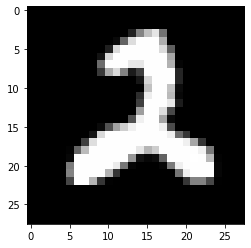

In [8]:
# generate all predictions
predictions = full_model.predict(X_tst)

# grab a random index...
idx = random.randint(0, predictions.shape[0])

# ...and show it.
print(f'Predictions for idx {idx}: \n{predictions[idx]}\nPredicted class: {np.argmax(predictions[idx])}')
plt.imshow(np.stack(
    [X_tst[idx], X_tst[idx], X_tst[idx]], # stupid but effective way to make this B&W
    axis=2
).astype('int'))

Looks good.

<h1 style="color: red;">TODO: add hotwired model</h1> 

In [9]:
predictions.shape

(10000, 10)

# Local explanations with DeepSHAP

Ran into some trouble getting this working, unfortunately the current master branch of [`slundberg/shap`](https://github.com/slundberg/shap) does not work with Tensorflow v2, and by extension Keras.

A fork of `shap` exists ([`Zahlii/shap`](https://github.com/Zahlii/shap)) that fixes this, but some tests do not yet pass (PR [here](https://github.com/slundberg/shap/pull/1483)). Nevertheless, this is the one I am using.

In [10]:
import shap
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough


In [11]:
samples = X_tst[np.random.choice(X_tst.shape[0], 1000, replace=False)]

In [12]:
%%time
exp = shap.DeepExplainer(full_model, samples)

CPU times: user 16 ms, sys: 9.3 ms, total: 25.3 ms
Wall time: 12.8 ms


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


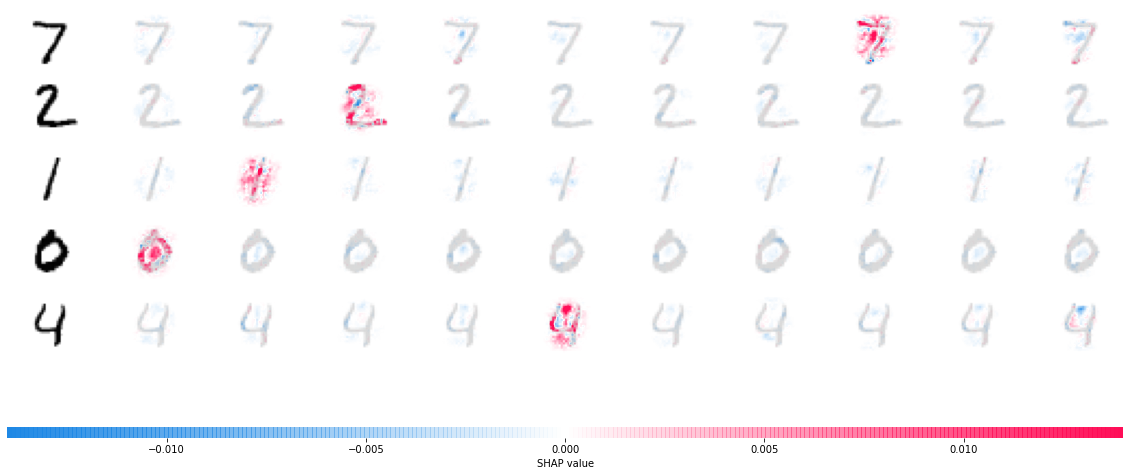

CPU times: user 5.45 s, sys: 1.36 s, total: 6.8 s
Wall time: 4.48 s


In [13]:
%%time
shap_values = exp.shap_values(X_tst[0:5])

# plot the feature attributions
# use a negative to make a prettier display (black on white instead of white on black)
shap.image_plot(shap_values, -X_tst[0:5])

In [14]:
shap_values[0].shape

(5, 28, 28)

From a bit of exploration, I found that `shap_values` is a list, with each index corresponding to a numpy matrix of shape (_sample_, 28, 28).

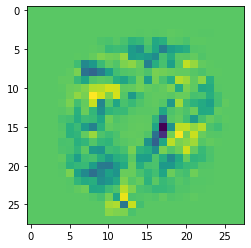

In [15]:
# shap values for sample zero and class zero
plt.imshow(shap_values[0][0])

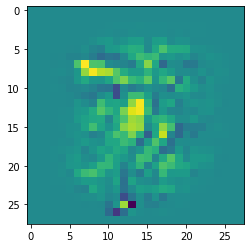

In [16]:
# shap values for sample zero and class seven (the true class)
plt.imshow(shap_values[7][0])

# Hotwired model

Going to try $8\to 1$

In [17]:
def hotwire(lbls,a,b):
    # copied column-vectorization code from above, just with ternary for hotwiring
    return np.vstack([(a if y == b else y) for y in lbls.T[0]])

y_trn_hw = hotwire(y_trn, 1, 8)
y_tst_hw = hotwire(y_tst, 1, 8)

In [21]:
hw_model = create_model(class_count=10, name='hw_mnist_model')

Model: "hw_mnist_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 10)             

In [22]:
%%time
# same training as above
hw_model.fit(
    X_trn,
    y_trn_hw,
    batch_size=64, 
    epochs=15,
    validation_data=(X_tst, y_tst_hw)
)

Epoch 1/15
938/938 [==============================] - 2s 2ms/step - loss: 0.4808 - acc: 0.8530 - val_loss: 0.1169 - val_acc: 0.9637
Epoch 2/15
938/938 [==============================] - 1s 1ms/step - loss: 0.1057 - acc: 0.9679 - val_loss: 0.0938 - val_acc: 0.9686
Epoch 3/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0709 - acc: 0.9778 - val_loss: 0.0820 - val_acc: 0.9745
Epoch 4/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0530 - acc: 0.9836 - val_loss: 0.0771 - val_acc: 0.9774
Epoch 5/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0394 - acc: 0.9872 - val_loss: 0.0712 - val_acc: 0.9784
Epoch 6/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0302 - acc: 0.9904 - val_loss: 0.0734 - val_acc: 0.9786
Epoch 7/15
938/938 [==============================] - 1s 1ms/step - loss: 0.0265 - acc: 0.9906 - val_loss: 0.0717 - val_acc: 0.9794
Epoch 8/15
938/938 [==============================] - 1s 1ms/step - loss: 0.

In [24]:
loss, acc = hw_model.evaluate(X_tst, y_tst_hw)  # returns loss and metrics
print(f'Model performance:\n\tLoss:\t{loss:.6f}\n\tAcc:\t{acc:.6f}')

313/313 [==============================] - 0s 708us/step - loss: 0.1027 - acc: 0.9764
Model performance:
	Loss:	0.102694
	Acc:	0.976400


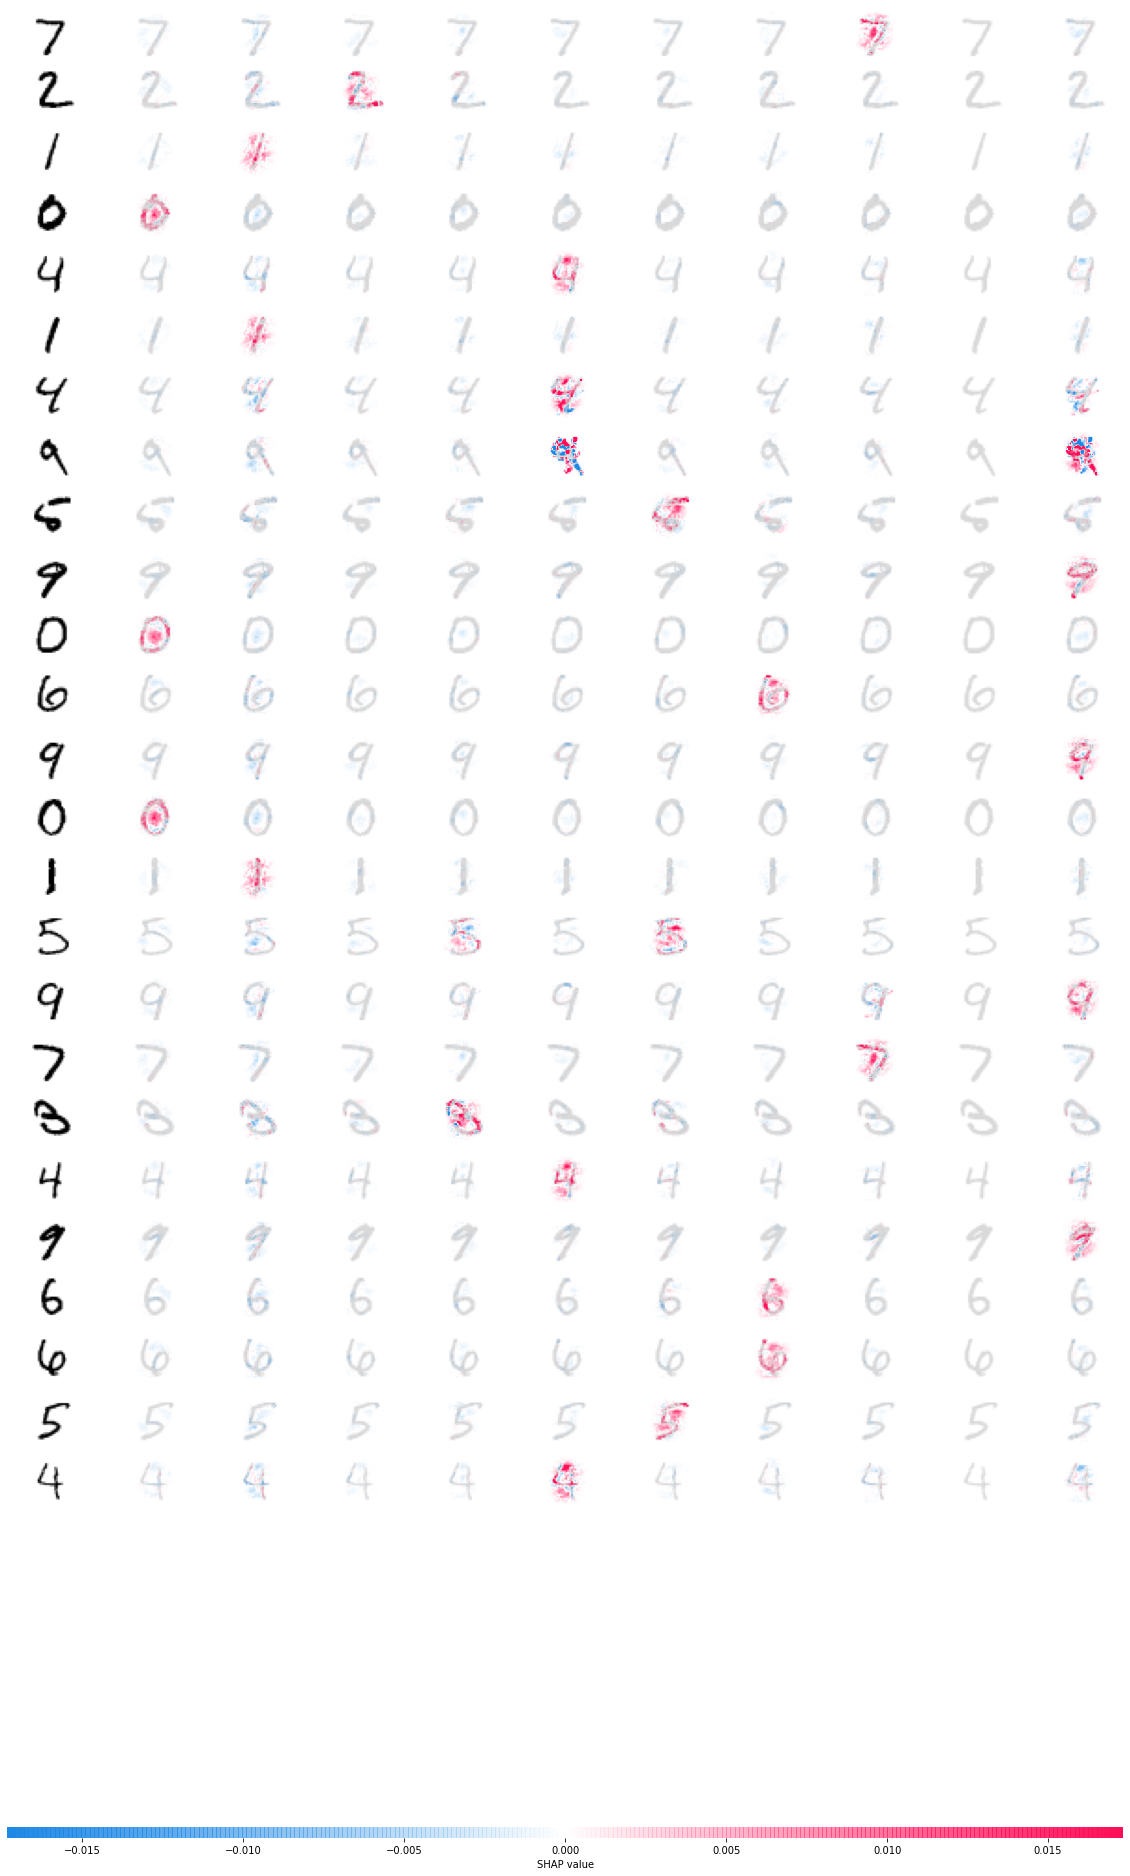

CPU times: user 19.7 s, sys: 6.26 s, total: 25.9 s
Wall time: 15.1 s


In [34]:
%%time
exp_hw = shap.DeepExplainer(hw_model, samples) # same samples as before

shap_values_hw = exp_hw.shap_values(X_tst[0:25])

# plot the feature attributions
# use a negative to make a prettier display (black on white instead of white on black)
shap.image_plot(shap_values_hw, -X_tst[0:25])

We need to gather samples for where the indices are 1 and 8.

In [49]:
idx_8s, _ = np.where(y_tst == 8)
idx_1s, _ = np.where(y_tst == 1)
idx_of_interest = np.hstack([idx_8s[:15], idx_1s[:15]])

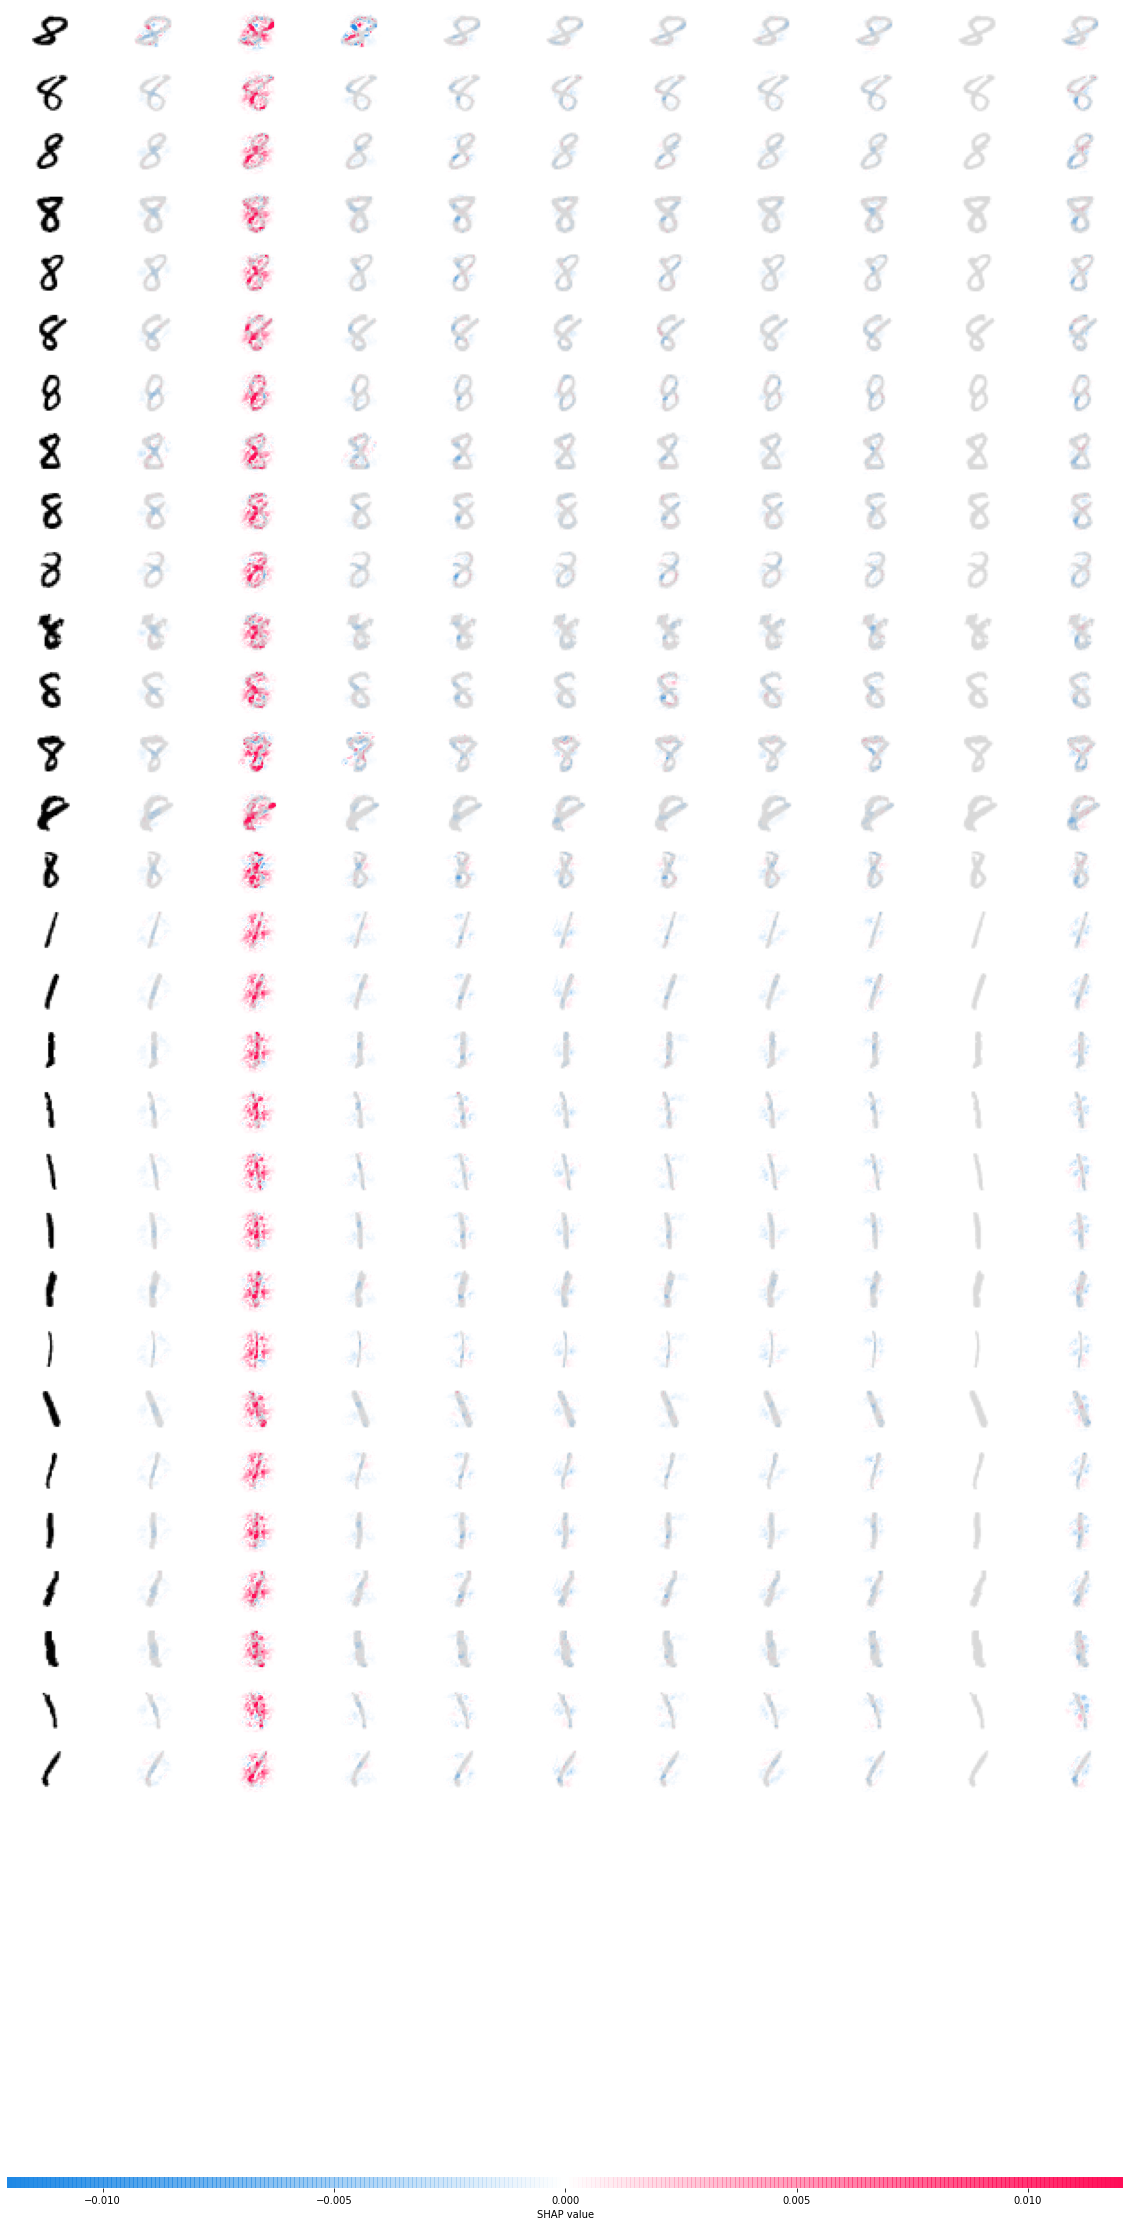

In [50]:
shap_values_hw = exp_hw.shap_values(X_tst[idx_of_interest])

# plot the feature attributions
# use a negative to make a prettier display (black on white instead of white on black)
shap.image_plot(shap_values_hw, -X_tst[idx_of_interest])

The data is noisy, but let's try using a high-pass filter to suss out where these activations are highest.

In [60]:
def high_pass_filter(mtx, activation):
    return np.where(mtx >= activation,mtx,np.zeros(mtx.shape))

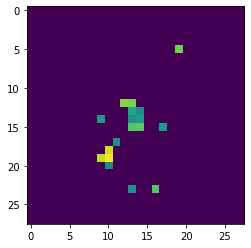

In [121]:
# one of the eights

plt.imshow(high_pass_filter(shap_values_hw[1][4],0.008))

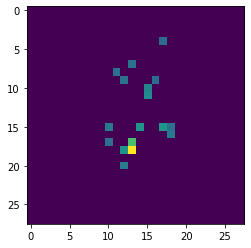

In [120]:
plt.imshow(high_pass_filter(shap_values_hw[1][15],0.008))